# Decoding Match-Mismatch Response Cross the Subjects

In [220]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from collections import Counter
%matplotlib inline

In [221]:
def score_func(y, y_pred):
    score = roc_auc_score(y, y_pred, multi_class="ovo")
    return score

In [222]:
my_scores = make_scorer(score_func=score_func, greater_is_better=True, needs_proba=True, needs_threshold=False)

## Set the path and load the dataset

In [223]:
os.getcwd()

'/Users/zhengyuanrui/Decoding_SALT/2_Data'

In [224]:
os.chdir("../2_Data")

In [225]:
df2 = pd.read_csv("Exp2_postpro.csv")

In [226]:
df2.head()

,subj_idx,gender,year,education,dist,trial_type,rt,response,key_press,condition,correct_response,correct,word,Image,shape_en,valence,ACC,exp,matchness,trial_id
0,1,0,2000,5,408.81,psychophysics,822.0,f,f,image_first,f,True,常人,img/S_ambi40.png,square,Neutral,1,exp2,mismatch,1
1,1,0,2000,5,408.81,psychophysics,741.0,f,f,image_first,f,True,好人,img/T_ambi40.png,triangle,Good,1,exp2,mismatch,2
2,1,0,2000,5,408.81,psychophysics,781.0,j,j,image_first,j,True,常人,img/T_ambi40.png,triangle,Neutral,1,exp2,match,3
3,1,0,2000,5,408.81,psychophysics,683.0,f,f,image_first,f,True,坏人,img/C_ambi40.png,circle,Bad,1,exp2,mismatch,4
4,1,0,2000,5,408.81,psychophysics,599.0,j,j,image_first,j,True,常人,img/T_ambi40.png,triangle,Neutral,1,exp2,match,5


## Select the columns and split the dataset by condition

In [227]:
column = ['subj_idx', 'gender', 'year','education', 'condition', 'valence', 'matchness', 'rt', 'ACC', 'trial_id']

In [228]:
df2 = df2[column]

In [229]:
df2.head()

,subj_idx,gender,year,education,condition,valence,matchness,rt,ACC,trial_id
0,1,0,2000,5,image_first,Neutral,mismatch,822.0,1,1
1,1,0,2000,5,image_first,Good,mismatch,741.0,1,2
2,1,0,2000,5,image_first,Neutral,match,781.0,1,3
3,1,0,2000,5,image_first,Bad,mismatch,683.0,1,4
4,1,0,2000,5,image_first,Neutral,match,599.0,1,5


In [230]:
onehot_v = pd.get_dummies(df2["valence"], prefix="valence")

In [231]:
df2 = pd.concat([df2, onehot_v], axis=1)

In [232]:
df2 = df2.drop("valence", axis=1)

In [233]:
df2["matchness"] = df2["matchness"].map(dict(mismatch=0, match=1))

In [234]:
df2.head()

,subj_idx,gender,year,education,condition,matchness,rt,ACC,trial_id,valence_Bad,valence_Good,valence_Neutral
0,1,0,2000,5,image_first,0,822.0,1,1,0,0,1
1,1,0,2000,5,image_first,0,741.0,1,2,0,1,0
2,1,0,2000,5,image_first,1,781.0,1,3,0,0,1
3,1,0,2000,5,image_first,0,683.0,1,4,1,0,0
4,1,0,2000,5,image_first,1,599.0,1,5,0,0,1


In [235]:
df2["rt_log"] = np.log(df2["rt"])

In [236]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subj_idx         21600 non-null  int64  
 1   gender           21600 non-null  int64  
 2   year             21600 non-null  int64  
 3   education        21600 non-null  int64  
 4   condition        21600 non-null  object 
 5   matchness        21600 non-null  int64  
 6   rt               21523 non-null  float64
 7   ACC              21600 non-null  int64  
 8   trial_id         21600 non-null  int64  
 9   valence_Bad      21600 non-null  uint8  
 10  valence_Good     21600 non-null  uint8  
 11  valence_Neutral  21600 non-null  uint8  
 12  rt_log           21523 non-null  float64
dtypes: float64(2), int64(7), object(1), uint8(3)
memory usage: 1.7+ MB


In [237]:
df2_sim = df2[df2.condition == "simultaneous"]

In [238]:
df2_img = df2[df2.condition == "image_first"]

In [239]:
df2_word = df2[df2.condition == "word_first"]

In [240]:
df2_sim.head()

,subj_idx,gender,year,education,condition,matchness,rt,ACC,trial_id,valence_Bad,valence_Good,valence_Neutral,rt_log
480,1,0,2000,5,simultaneous,0,980.0,1,1,1,0,0,6.887553
481,1,0,2000,5,simultaneous,0,779.0,1,2,0,0,1,6.658011
482,1,0,2000,5,simultaneous,1,738.0,1,3,0,1,0,6.603944
483,1,0,2000,5,simultaneous,1,763.0,1,4,0,0,1,6.637258
484,1,0,2000,5,simultaneous,1,660.0,1,5,0,1,0,6.492240


In [241]:
df2_img.head()

,subj_idx,gender,year,education,condition,matchness,rt,ACC,trial_id,valence_Bad,valence_Good,valence_Neutral,rt_log
0,1,0,2000,5,image_first,0,822.0,1,1,0,0,1,6.711740
1,1,0,2000,5,image_first,0,741.0,1,2,0,1,0,6.608001
2,1,0,2000,5,image_first,1,781.0,1,3,0,0,1,6.660575
3,1,0,2000,5,image_first,0,683.0,1,4,1,0,0,6.526495
4,1,0,2000,5,image_first,1,599.0,1,5,0,0,1,6.395262


In [242]:
df2_word.head()

,subj_idx,gender,year,education,condition,matchness,rt,ACC,trial_id,valence_Bad,valence_Good,valence_Neutral,rt_log
240,1,0,2000,5,word_first,0,761.0,1,1,0,0,1,6.634633
241,1,0,2000,5,word_first,0,745.0,1,2,0,1,0,6.613384
242,1,0,2000,5,word_first,1,639.0,1,3,1,0,0,6.459904
243,1,0,2000,5,word_first,1,566.0,1,4,0,1,0,6.338594
244,1,0,2000,5,word_first,1,510.0,1,5,0,1,0,6.234411


In [243]:
Counter(df2_sim["ACC"])

Counter({1: 6494, 0: 706})

In [244]:
Counter(df2_img["ACC"])

Counter({1: 6581, 0: 619})

In [245]:
Counter(df2_word["ACC"])

Counter({1: 6563, 0: 637})

In [246]:
pipe_lr = make_pipeline(
    MinMaxScaler(), 
    LogisticRegression(solver='saga', multi_class="multinomial", max_iter=1000, random_state=123)
)

In [247]:
logo = LeaveOneGroupOut()

In [248]:
df2_sim = df2_sim.dropna()

In [249]:
y_sim = df2_sim["matchness"].values

In [250]:
y_sim.shape

(7160,)

In [251]:
X_sim = df2_sim[['rt_log', "ACC", "valence_Good", "valence_Neutral", "valence_Bad"]].values

In [252]:
X_sim.shape

(7160, 5)

In [253]:
sim_groups = df2_sim["subj_idx"].values

In [254]:
np.unique(sim_groups)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [255]:
sim_scores_lr = cross_validate(pipe_lr, X_sim, y_sim, groups=sim_groups, cv=logo, scoring=my_scores)

In [256]:
sim_scores_lr['test_score'].mean()

0.6199630282690866

In [257]:
score_sim_lr, perm_scores_sim_lr, pvalue_sim_lr = permutation_test_score(pipe_lr, X_sim, y_sim, cv=logo, groups=sim_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.1s finished


In [258]:
pi_mean = []
pi_std = []
from sklearn.inspection import permutation_importance
for train_ix, test_ix in logo.split(X = X_sim, groups=sim_groups):
    X_train, X_test = X_sim[train_ix, :], X_sim[test_ix, :]
    y_train, y_test = y_sim[train_ix], y_sim[test_ix]
    clf = pipe_lr.fit(X_train, y_train)
    result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)
    pi_mean.append(result["importances_mean"])
    pi_std.append(result["importances_std"])


In [259]:
pimean_df = pd.DataFrame(pi_mean)

In [264]:
pimean_df.columns = ['rt_log', "ACC", "valence_Good", "valence_Neutral", "valence_Bad"]

In [270]:
plot = pimean_df.melt(ignore_index=False)

In [262]:
import seaborn as sns

<AxesSubplot: xlabel='variable', ylabel='value'>

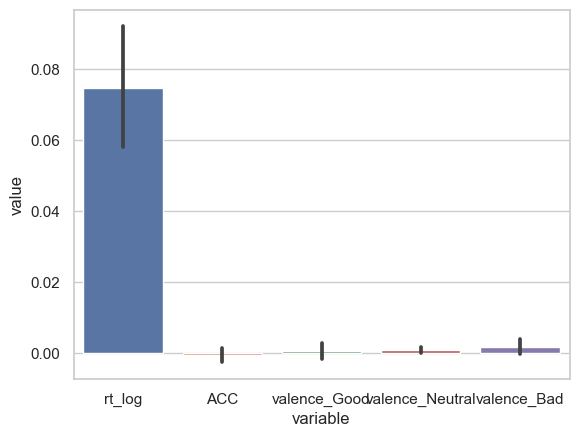

In [274]:
sns.set(style="whitegrid")
sns.barplot(plot, x = "variable", y = "value")